# cat-classifier
Here we build a deep neural-network for classifying cats.

> Inspired by: [Neural Networks and Deep Learning](https://www.coursera.org/learn/neural-networks-deep-learning?specialization=deep-learning)

In [ ]:
import numpy as np
from numpy.random import default_rng
from matplotlib import pyplot as plt
from tqdm import tqdm
import h5py

In [2]:
# importing train and test sets
test_f = h5py.File("../data/test-cat-classifier.h5", mode='r')
test_x = np.array(test_f['test_set_x'])
test_y = np.array(test_f['test_set_y'])

train_f = h5py.File("../data/train-cat-classifier.h5", mode='r')
train_x = np.array(train_f['train_set_x'])
train_y = np.array(train_f['train_set_y'])

print(f"Train-x: {train_x.shape}")
print(f"Train-y: {train_y.shape}")
print(f"Test-x: {test_x.shape}")
print(f"Test-x: {test_y.shape}")

train_f.close()
test_f.close()

Train-x: (209, 64, 64, 3)
Train-y: (209,)
Test-x: (50, 64, 64, 3)
Test-x: (50,)


## # pre-processing train & test sets
The following pre-processing methods are used:
 1. Method-1:
    - Flatten each image into a single vector of dimension (num_px * num_px * 3)
    - Center and standardize the dataset:
        - Compute the mean and standard-Diviation for each component/element, of all the training examples
        - Subtract the above computed-mean from each component/element, of all training examples
        - Divide each training example by the above computed standard-deviation
 2. Method-2: (_only for picture datasets_)
    - Flatten each image into a single vector of dimension (num_px * num_px * 3)
    - Divide every trainig example by 255 - the maximum value of any color-channel.

In [3]:
def pre_process(method):
    X_train = train_x.reshape((train_x.shape[0], -1)).copy().T
    Y_train = train_y.reshape((1, train_y.shape[0])).copy()

    X_test = test_x.reshape((test_x.shape[0], -1)).copy().T
    Y_test = test_y.reshape((1, test_y.shape[0])).copy()
    

    if method == 1:
        print(f"Pre-processing data-set... {{method: {method}}} (mean & variance normalization)")
        
        train_mean = np.mean(X_train, axis=1).reshape((X_train.shape[0], 1))
        train_sd = np.std(X_train, axis=1).reshape((X_train.shape[0], 1))
        
        X_train = (X_train - train_mean) / train_sd
        X_test = (X_test - train_mean) / train_sd
    elif method == 2:
        print(f"Pre-processing data-set... {{method: {method}}} (division by 255)")
        X_test = X_test / 255.0
        X_train = X_train / 255.0
    else:
        raise ValueError(f"Invalid method {method}")
    
    print(f"X-train: {X_train.shape}")
    print(f"Y-train: {Y_train.shape}")
    print(f"X-test: {X_test.shape}")
    print(f"Y-test: {Y_test.shape}")

    return X_train, Y_train, X_test, Y_test

## # general-architecture
<div style="text-align:center">
    <img src="img/cat-classifier-nn-split.svg" />
    <br><b>Fig.1:</b> the black-colored arrows correspond to forward-propagation; the green-colored arrows correspond to the gradient-flow.
</div>

## # forward-propagation

The equations for forward propagation are as follows:

$$
\begin{aligned}
\mathbf{Z}^{[l]} & = (\mathbf{W}^{[l]})^\intercal \mathbf{A}^{[l-1]} + \mathbf{b}^{[l]}\vec{1}_{(1,m)} \\
\mathbf{A}^{[l]} & = f_{activation}(\mathbf{Z}^{[l]})\\
\mathbf{L}(\mathbf{a}^{[L]}, \mathbf{y}) & = -\mathbf{y}\circ\log(\hat{\mathbf{y}}) - (1 - \mathbf{y})\circ\log(1 - \hat{\mathbf{y}}) \\
J & = \frac{1}{m}\sum_{i = 1}^{m}L(\hat{y}^{(i)}, y^{(i)})  = \frac{1}{m}\mathbf{L}\vec{1}_{(m,1)} \\
\end{aligned}
$$

\begin{align*}
\text{where, } & m && \text{is the number of training-examples} \\
& L && \text{is the number of layers, i.e. network-depth} \\
& \mathbf{W}^{[l]} &&\text{is a $(n^{[l-1]}, n^{[l]})$ dimensional Weight-matrix}\\
& \mathbf{A}^{[l-1]} &&\text{is a $(n^{[l-1]}, m)$ dimenstional activation-vector; and, }\mathbf{A}^{[0]} = \mathbf{X} \\
& \mathbf{b}^{[l]} &&\text{is a $(n^{[l]}, 1)$ dimenstional bias-vector} \\
& \vec{1}_{(1,m)} && \text{is a $(1, m)$ dimensional vector of all 1's.} \\
& &&\text{Multiplying this with $ \mathbf{b}^{[l]}$ has the same effect as python broadcasting.} \\
& f_{activation}() &&\text{is ReLU for all hidden-layers; is Sigmoid for the output-layer} \\
& \hat{\mathbf{y}} && = \mathbf{a}^{[4]}\text{, the result of the output-layer} \\
& \mathbf{L} &&\text{is the cross-entropy loss-function, and is a $(1,m)$ row vector}\\
& J && \text{is the cross-entropy cost-function}
\end{align*}

**Note**: The underlying implementation is generalized, in-terms of the number of layers and their dimensions, i.e. the implementation should work for any network-size.

In [4]:
def sigmoid(Z: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-Z))

def relu(Z: np.ndarray) -> np.ndarray:
    return np.maximum(Z, 0)

def linear(W: np.ndarray, A: np.ndarray, b: np.ndarray) -> np.ndarray:
    return np.matmul(W.T, A) + b

def activation(Zl: np.ndarray, func_name: str) -> np.ndarray:
    if func_name == 'sigmoid':
        return sigmoid(Zl)
    elif func_name == 'relu':
        return relu(Zl)
    else:
        raise ValueError(f"Unknown activation-function: {func_name}")

def forward_propogate(X: np.ndarray, model: dict) -> tuple:
    L: int = model["L"]
    
    cache = {'c-l0': (X, None, None, None)}

    Al_1 = X
    Al = None
    for l in range(L):
        Wl = model['W-l' + str(l + 1)]
        bl = model['b-l' + str(l + 1)]
        Zl = linear(Wl, Al_1, bl)
        Al = activation(Zl, model['g-l' + str(l + 1)])
        cache['c-l' + str(l + 1)] = (Al.copy(), Wl.copy(), bl.copy(), Zl.copy())
        
        Al_1 = Al
    
    return Al, cache

def cost(Al: np.ndarray, Y: np.ndarray, **kwargs) -> float:
    """
    Assumes Y and Al to be (1,m) dimensional vectors
    """
    assert Al.shape == Y.shape

    return np.sum(-Y * np.log(Al) - (1 - Y) * np.log(1 - Al)) / Y.shape[1]

## # gradient-descent
The optimization is performed according to the following equations:

$$
\begin{aligned}
\mathbf{W}^{[l]} & := \mathbf{W}^{[l]} - \alpha\nabla_{\mathbf{W}^{[l]}}(J) \\
\mathbf{b}^{[l]} & := \mathbf{b}^{[l]} - \alpha\nabla_{\mathbf{b}^{[l]}}(J) \\
& \text{where, $\alpha$ is the learning-rate/step-size.}
\end{aligned}
$$

The following derivatives are jacobians:

$$
\begin{aligned}
& \frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}} && = \frac{\mathrm{d}J}{\mathrm{d}\mathbf{A}^{[l]}} \circ
\begin{bmatrix}
\mathrm{diag}^{-1}\biggl(\frac{\mathrm{d}\mathbf{A}^{[l](1)}}{\mathrm{d}\mathbf{Z}^{[l](1)}}\biggr)^\intercal \\
\vdots\\
\mathrm{diag}^{-1}\biggl(\frac{\mathrm{d}\mathbf{A}^{[l](m)}}{\mathrm{d}\mathbf{Z}^{[l](m)}}\biggr)^\intercal
\end{bmatrix} \\
&\frac{\mathrm{d}J}{\mathrm{d}\mathbf{W}^{[l]}} && = \biggl(\frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}}\biggr)^\intercal (\mathbf{A}^{[l-1]})^\intercal  \\
&\frac{\mathrm{d}J}{\mathrm{d}\mathbf{b}^{[l]}} && = \vec{1}_{(1,m)} \frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}} \\
&\frac{\mathrm{d}J}{\mathrm{d}\mathbf{A}^{[l-1]}} && = \frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}} (\mathbf{W}^{[l]})^\intercal  \\
\end{aligned}
$$
And, the gradients are simply the transpose of these jacobians, i.e.

$$
\begin{aligned}
\nabla_{\mathbf{W}^{[l]}}\big(J\big) & = \bigg(\frac{\mathrm{d}J}{\mathrm{d}\mathbf{W}^{[l]}}\bigg)^\intercal && = \mathbf{A}^{[l-1]} \frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}} \\
\nabla_{\mathbf{b}^{[l]}}\big(J\big) & = \bigg(\frac{\mathrm{d}J}{\mathrm{d}\mathbf{b}^{[l]}}\bigg)^\intercal && = \biggl(\frac{\mathrm{d}J}{\mathrm{d}\mathbf{Z}^{[l]}}\biggr)^\intercal (\vec{1}_{(1,m)})^\intercal  \\
\end{aligned}
$$

> **Note**: for detailed of derivation of these jacobians using back-propagation, see [`.\back-propagation.pdf`](.\back-propagation.pdf).

* When $l = 4$ (i.e., the output-layer), we have

$$
\frac{\mathrm{d}J}{\mathrm{d}\mathbf{A}^{[4]}} = \biggl(\frac{\mathrm{d}J}{\mathrm{d}(\mathbf{a}^{[4]})^\intercal}\biggr)^\intercal = \frac{1}{m}
\begin{bmatrix}
\frac{\partial L^{(1)}}{\partial a^{[4](1)}} \\
\frac{\partial L^{(2)}}{\partial a^{[4](2)}} \\
\vdots \\
\frac{\partial L^{(m)}}{\partial a^{[4](m)}}
\end{bmatrix}
$$

$$
\begin{aligned}
\text{where, } \frac{\partial L^{(i)}}{\partial a^{[4](i)}} & = -\frac{y^{(i)}}{a^{[4](i)}} + \frac{1 - y^{(i)}}{1 - a^{[4](i)}} \\
& = \frac{a^{[4](i)} - y^{(i)}}{a^{[4](i)}(1 - a^{[4](i)})} \\
\end{aligned}
$$

* When $f_{activation}$ = `sigmoid`, we have
$$
\begin{aligned}
\qquad \mathrm{diag}^{-1}\biggl(\frac{\mathrm{d}\mathbf{A}^{[l](i)}}{\mathrm{d}\mathbf{Z}^{[l](i)}}\biggr)^\intercal & = \begin{bmatrix}
\frac{\mathrm{d}a^{[l](i)}_{1}}{\mathrm{d}z^{[l](i)}_{1}} & \frac{\mathrm{d}a^{[l](i)}_{2}}{\mathrm{d}z^{[l](i)}_{2}} 
& \dots & \frac{\mathrm{d}a^{[l](i)}_{n^{[l]}}}{\mathrm{d}z^{[l](i)}_{n^{[l]}}}\\
\end{bmatrix} \\
& = \begin{bmatrix}
a^{[l](i)}_{1} (1 - a^{[l](i)}_{1}) &
a^{[l](i)}_{2} (1 - a^{[l](i)}_{2}) &
\dots &
a^{[l](i)}_{n^{[l]}} (1 - a^{[l](i)}_{n^{[l]}}) \\
\end{bmatrix} \\
& = (\mathbf{A}^{[l](i)})^\intercal \circ (1 - (\mathbf{A}^{[l](i)})^\intercal)\\
\end{aligned}
$$

$\qquad\qquad$ generalizing the above result over all $m$-examples, we get
$$
\begin{bmatrix}
\mathrm{diag}^{-1}\biggl(\frac{\mathrm{d}\mathbf{A}^{[l](1)}}{\mathrm{d}\mathbf{Z}^{[l](1)}}\biggr)^\intercal \\ 
\vdots \\
\mathrm{diag}^{-1}\biggl(\frac{\mathrm{d}\mathbf{A}^{[l](m)}}{\mathrm{d}\mathbf{Z}^{[l](m)}}\biggr)^\intercal \\
\end{bmatrix} = (\mathbf{A}^{[l]})^\intercal \circ (1 - (\mathbf{A}^{[l]})^\intercal)
$$

* When $f_{activation}$ = `relu`, we have
$$
\begin{aligned}
\qquad \mathrm{diag}^{-1}\biggl(\frac{\mathrm{d}\mathbf{A}^{[l](i)}}{\mathrm{d}\mathbf{Z}^{[l](i)}}\biggr)^\intercal & = \begin{bmatrix}
\frac{\mathrm{d}a^{[l](i)}_{1}}{\mathrm{d}z^{[l](i)}_{1}} &
\frac{\mathrm{d}a^{[l](i)}_{2}}{\mathrm{d}z^{[l](i)}_{2}} &
\dots &
\frac{\mathrm{d}a^{[l](i)}_{n^{[l]}}}{\mathrm{d}z^{[l](i)}_{n^{[l]}}}\\
\end{bmatrix} \\
& = \begin{bmatrix}
h(z^{[l](i)}_{1}) &
h(z^{[l](i)}_{2}) &
\dots &
h(z^{[l](i)}_{n^{[l]}}) \\
\end{bmatrix} \\
& = h(\mathbf{Z}^{[l](i)})^\intercal
 \end{aligned}
$$

$\qquad\qquad$ generalizing the above result over all $m$-examples, we get
$$
\begin{bmatrix}
\mathrm{diag}^{-1}\biggl(\frac{\mathrm{d}\mathbf{A}^{[l](1)}}{\mathrm{d}\mathbf{Z}^{[l](1)}}\biggr)^\intercal \\ 
\vdots \\
\mathrm{diag}^{-1}\biggl(\frac{\mathrm{d}\mathbf{A}^{[l](m)}}{\mathrm{d}\mathbf{Z}^{[l](m)}}\biggr)^\intercal \\
\end{bmatrix} = h(\mathbf{Z}^{[l]})^\intercal
$$

$\qquad\qquad$ where, $h(\mathbf{X})$ is an element-wise operation on $\mathbf{X}$, such that
$$
h(x_{ij}) = 
\begin{cases}
1, & \text{if } x_{ij} \gt 0 \\
0, & \text{if } x_{ij} \le 0 \\
\end{cases}
$$

In [5]:
def update_model(l: int, cache: dict, model: dict, dZl: np.ndarray, 
                 alpha: float, m: int, **kwargs):
    assert l > 0, f"Invalid layer-number {l}"

    # updating Wl
    Al_1 = cache['c-l' + str(l - 1)][0]
    dWl = np.matmul(dZl.T, Al_1.T) 
    model['W-l' + str(l)] += -alpha * dWl.T

    # updating bl
    dbl = np.matmul(np.ones((1, m)), dZl)
    model['b-l' + str(l)] += -alpha * dbl.T

    # computing dAl_1
    Wl = cache['c-l' + str(l)][1]
    dAl_1 = np.matmul(dZl, Wl.T)

    return dAl_1, dWl, dbl

def gradient_descent(X: np.ndarray, Y: np.ndarray, model: dict, 
        num_iters: int = 3000, alpha: float = 0.0075,
        debug_mode=False, debug_per_iter: int=100,

        # override for other funcationality
        update_model=update_model,
        forward_propogate=forward_propogate,
        cost_function=cost, **kwargs):

    L = model["L"]
    m = X.shape[1]
    
    train_cache = list() if debug_mode else None

    print(f"Gradient-descent... {{alpha: {alpha}, num_iters: {num_iters}}}")
    print(f"................... {{gradient_func: {update_model.__name__}, cost_func: {cost_function.__name__}}}")
    print(f"................... {{forward_prop_func: {forward_propogate.__name__}}}")
    
    gradient_cache = None
    iter_cost = None
    for i in tqdm(range(num_iters)):
        Al, forward_cache = forward_propogate(X, model=model)

        if debug_mode:
            if i % debug_per_iter == 0:
                gradient_cache = dict()
                iter_cost = cost_function(Al, Y, model=model, **kwargs)
                # print(f"Cost after {i}-backprops: {iter_cost}")

        # must be (m,1) dimensional
        dAl = np.transpose((Al - Y) / np.multiply(Al, 1 - Al)) / np.float64(m)
        dZl = None
        for l in reversed(range(1, L+1)):
            Al, Wl, bl, Zl = forward_cache['c-l' + str(l)]
            if model['g-l' + str(l)] == 'relu':
                dZl = np.multiply(dAl, np.where(Zl > 0, 1, 0).T)
            elif model['g-l' + str(l)] == 'sigmoid':
                dZl = np.multiply(dAl, np.multiply(Al, 1 - Al).T)
            else:
                raise ValueError(f"Unknown activation-function {model['g-l' + str(l)]}")
            
            dAl_1, dWl, dbl = update_model(l, forward_cache, model, dZl, alpha, m, **kwargs)

            if debug_mode:
                if i % debug_per_iter == 0:
                    gradient_cache['dc-l' + str(l)] = \
                        (dAl.copy(), dWl.copy(), dbl.copy(), dZl.copy())

            dAl = dAl_1 # propagating the activation gradient

        if debug_mode:
            if i % debug_per_iter == 0:
                train_cache.append((i, iter_cost, forward_cache, gradient_cache))
            
        if np.isnan(iter_cost):
            print(f"iter-{i}... NaN-Abort!")
            return model, train_cache

    return model, train_cache

def threshold_classify(Al, threshold: float=0.5):
    return np.where(Al > threshold, 1, 0)

def measure_accuracy(X_train: np.ndarray, X_test: np.ndarray, 
        Y_train: np.ndarray, Y_test: np.ndarray, model: dict):
    Al, _ = forward_propogate(X_train, model)
    train_acc = 100 * np.sum(threshold_classify(Al) == Y_train) / X_train.shape[1]
    
    Al, _ = forward_propogate(X_test, model)
    test_acc = 100 * np.sum(threshold_classify(Al) == Y_test) / X_test.shape[1]

    print(f"Train accuracy: {np.round(train_acc, 3)}%")
    print(f"Test accuracy: {np.round(test_acc, 3)}%")

In [6]:
def initialize(n_x: int, layers: list, scale: float = 0.01, 
            scaling_type: str='uniform', **kwargs) -> dict:
    print(f"Initializing parameters... {{scaling-type: {scaling_type}, default-scale: {scale}}}")
    print(f".......................... {{layers: {layers}}}")

    rng = default_rng(1)
    model = dict()
    
    model['L'] = len(layers)
    diml_1 = n_x
    for l, diml in enumerate(layers):
        if scaling_type == 'xavier':
            scale_factor = 1 / np.sqrt(diml_1)
        elif scaling_type == 'yoshua':
            scale_factor = np.sqrt(2 / (diml + diml_1))
        elif scaling_type == 'he':
            if str(l+1) != len(layers):
                # same as the criteria used below for deciding the activation-function
                scale_factor = np.sqrt(2 / diml_1)
            else:
                scale_factor = scale
        else:
            scale_factor = scale

        model['W-l' + str(l + 1)] = rng.standard_normal(
            size=(diml_1, diml), dtype=np.float64) * scale_factor
        model['b-l' + str(l + 1)] = rng.standard_normal(
            size=(diml, 1), dtype=np.float64)
        # relu for all, sigmoid for last    
        model['g-l' + str(l + 1)] = 'relu' if l + 1 != len(layers) else 'sigmoid'
        
        diml_1 = diml

    return model

def model(layer_dims:list, pre_process_method: int, iterations: int, alpha: float, 
            debug: bool=False, debug_per_iter: int=100, **kwargs):
    X_train, Y_train, X_test, Y_test = pre_process(pre_process_method)
    params = initialize(n_x=X_train.shape[0], layers=layer_dims, **kwargs)
    params, train_cache = gradient_descent(X_train, Y_train, params, alpha=alpha, 
        num_iters=iterations, debug_mode=debug, debug_per_iter=debug_per_iter, **kwargs)
    measure_accuracy(X_train, X_test, Y_train, Y_test, params)

    if train_cache is not None:
        y = [cache[1] for cache in train_cache]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
        ax.plot(y)
        ax.set_title("Cost-function vs Iteration")
        ax.set_ylabel("cost-function ($J$)")
        ax.set_xlabel("training-iteration ($i$)")

        plt.show()
    
    return params, train_cache

## # 2-layer neural-network
Here we train a 2-layer neural-network defined as, 

$n^{[1]} = 7$ and $n^{[2]} = 1$.

Pre-processing data-set... {method: 2} (division by 255)
X-train: (12288, 209)
Y-train: (1, 209)
X-test: (12288, 50)
Y-test: (1, 50)
Initializing parameters... {scaling-type: uniform, default-scale: 0.01}
.......................... {layers: [7, 1]}
Gradient-descent... {alpha: 0.0075, num_iters: 2500}
................... {gradient_func: update_model, cost_func: cost}
................... {forward_prop_func: forward_propogate}


100%|██████████| 2500/2500 [00:43<00:00, 57.72it/s]


Train accuracy: 100.0%
Test accuracy: 72.0%


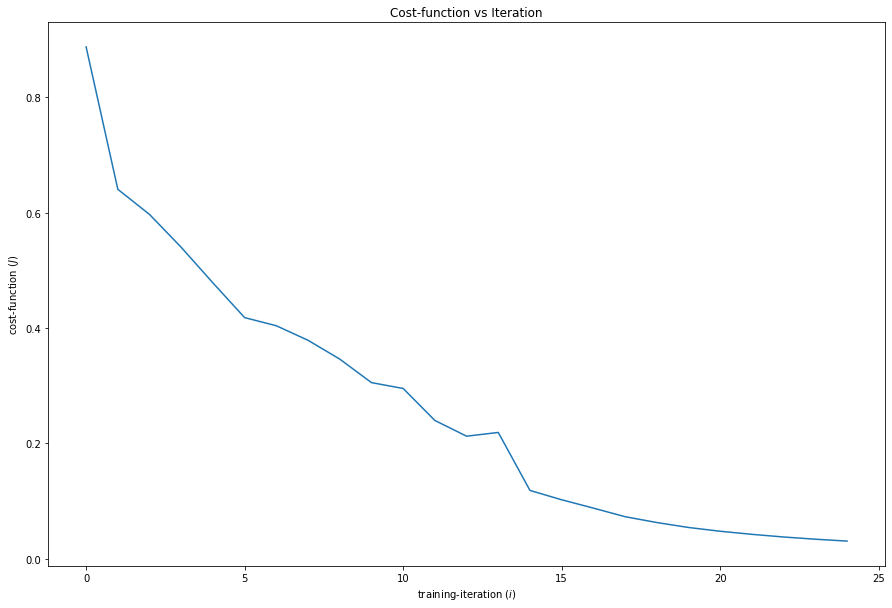

In [7]:
params, train_cache = model(layer_dims=[7,1], pre_process_method=2, 
    iterations=2500, alpha=0.0075, debug=True)

## # 4-layer neural-network
Here we train a 4-layer neural network with,

$n^{[1]} = 20$, $n^{[2]} = 7$, $n^{[3]} = 5$, $n^{[4]} = 1$

Pre-processing data-set... {method: 2} (division by 255)
X-train: (12288, 209)
Y-train: (1, 209)
X-test: (12288, 50)
Y-test: (1, 50)
Initializing parameters... {scaling-type: xavier, default-scale: 1}
.......................... {layers: [20, 7, 5, 1]}
Gradient-descent... {alpha: 0.0075, num_iters: 2500}
................... {gradient_func: update_model, cost_func: cost}
................... {forward_prop_func: forward_propogate}


100%|██████████| 2500/2500 [01:00<00:00, 41.59it/s]


Train accuracy: 100.0%
Test accuracy: 78.0%


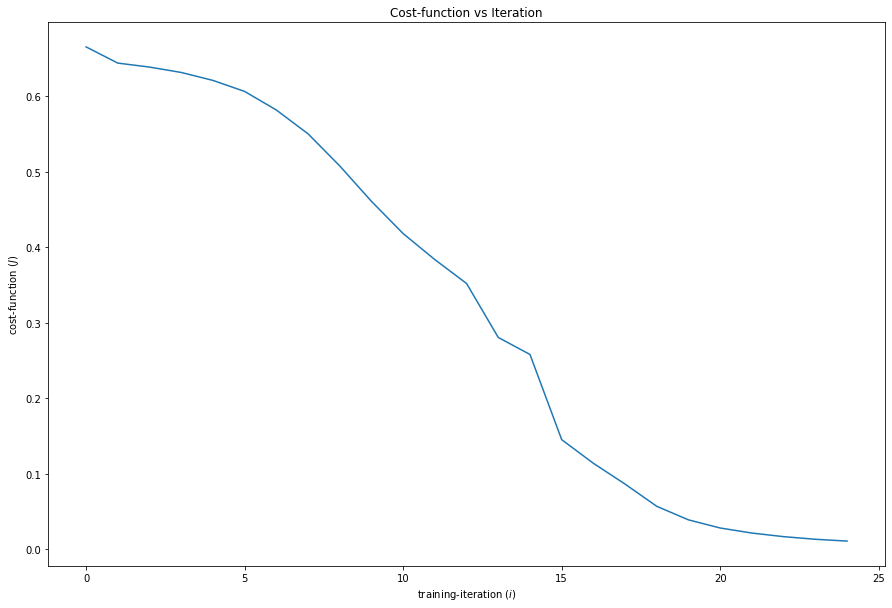

In [8]:
params, train_cache = model(layer_dims=[20, 7, 5, 1], pre_process_method=2, 
    iterations=2500, alpha=0.0075, debug=True, scaling_type='xavier', scale=1)

However, pre-processing the dataset with mean and variance normalization (i.e., method-1) is resulting worse performance (see below). So, to improve the performance of the model, I will have to do more hyper-parameter tuning.

Pre-processing data-set... {method: 1} (mean & variance normalization)
X-train: (12288, 209)
Y-train: (1, 209)
X-test: (12288, 50)
Y-test: (1, 50)
Initializing parameters... {scaling-type: xavier, default-scale: 1}
.......................... {layers: [20, 7, 5, 1]}
Gradient-descent... {alpha: 0.0075, num_iters: 2500}
................... {gradient_func: update_model, cost_func: cost}
................... {forward_prop_func: forward_propogate}


100%|██████████| 2500/2500 [01:03<00:00, 39.18it/s]


Train accuracy: 100.0%
Test accuracy: 74.0%


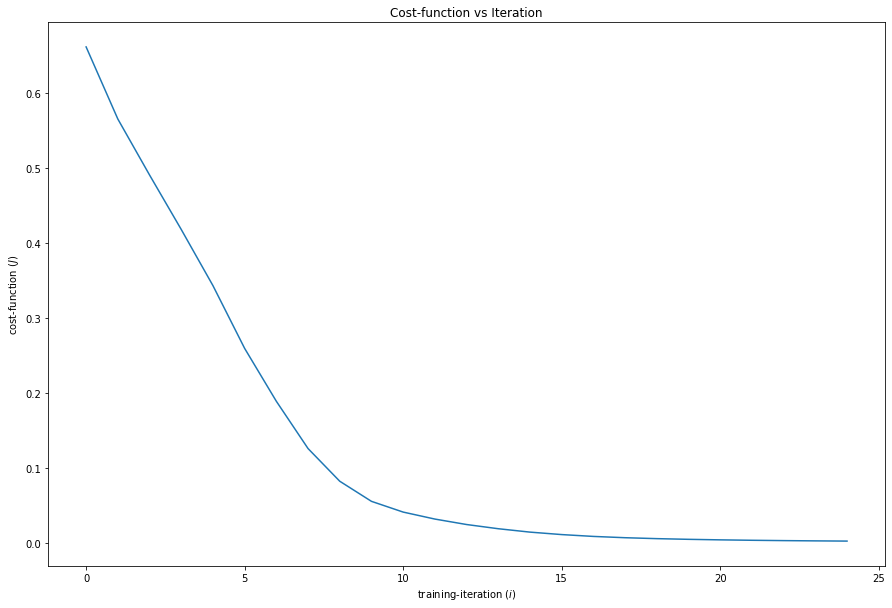

In [7]:
params, train_cache = model(layer_dims=[20, 7, 5, 1], pre_process_method=1, 
    iterations=2500, alpha=0.0075, debug=True, scaling_type='xavier', scale=1)